In [24]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [26]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split, KFold
import random
from nltk.corpus import wordnet
import re

In [27]:
# Load the dataset
url = "https://github.com/google-research-datasets/xsum_hallucination_annotations/raw/master/factuality_annotations_xsum_summaries.csv"
df = pd.read_csv(url)

In [28]:
# Convert 'is_factual' labels to binary (1 = factual, 0 = hallucinated)
df['is_factual'] = df['is_factual'].apply(lambda x: 1 if x == 'yes' else 0)

In [29]:
# Synonym Replacement Function
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

def synonym_replacement(text, n=3):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set(words))
    random.shuffle(random_word_list)
    num_replaced = 0

    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break

    return ' '.join(new_words)

In [30]:
# Data augmentation for factual samples
factual_samples = df[df['is_factual'] == 1]
num_hallucinated = len(df[df['is_factual'] == 0])
num_factual = len(factual_samples)

# Augmentation to balance the dataset
augmentations_per_sample = (num_hallucinated - num_factual) // num_factual + 1
augmented_texts = []
for summary in factual_samples['summary']:
    for _ in range(augmentations_per_sample):
        augmented_text = synonym_replacement(summary, n=3)
        augmented_texts.append(augmented_text)

# Create a new DataFrame for the augmented data
augmented_df = pd.DataFrame({'summary': augmented_texts, 'is_factual': 1})

# Combine original and augmented data
df_balanced = pd.concat([df, augmented_df])

# Check balance of classes
print(df_balanced['is_factual'].value_counts())

is_factual
1    5238
0    5015
Name: count, dtype: int64


In [31]:
# Split into training and test sets
X = df_balanced['summary'].values
y = df_balanced['is_factual'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Preprocessing: Tokenization and Bag-of-Words Vectorization
def tokenize(text):
    tokens = re.sub(r'\W+', ' ', text.lower()).split()
    return tokens

def build_vocabulary(texts):
    vocab = Counter()
    for text in texts:
        tokens = tokenize(text)
        vocab.update(tokens)
    return vocab

vocab = build_vocabulary(X_train)
vocab = {word: idx for idx, (word, _) in enumerate(vocab.items())}

def text_to_bow(text, vocab):
    tokens = tokenize(text)
    vector = np.zeros(len(vocab))
    for token in tokens:
        if token in vocab:
            vector[vocab[token]] += 1
    return vector

X_train_bow = np.array([text_to_bow(text, vocab) for text in X_train])
X_test_bow = np.array([text_to_bow(text, vocab) for text in X_test])

In [33]:
# Logistic Regression from Scratch
class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        self.theta = np.zeros(X.shape[1])
        self.bias = 0

        for _ in range(self.num_iterations):
            linear_model = np.dot(X, self.theta) + self.bias
            y_pred = self.sigmoid(linear_model)

            dw = (1 / len(y)) * np.dot(X.T, (y_pred - y))
            db = (1 / len(y)) * np.sum(y_pred - y)

            self.theta -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.theta) + self.bias
        y_pred = self.sigmoid(linear_model)
        y_pred_class = [1 if i > 0.5 else 0 for i in y_pred]
        return y_pred_class

# Training the Logistic Regression model
log_reg = LogisticRegressionScratch(learning_rate=0.01, num_iterations=1000)
log_reg.fit(X_train_bow, y_train)

Accuracy: 0.7186738176499269
Precision: 0.737006237006237
Recall: 0.686350435624395
F1 Score: 0.7107769423558897


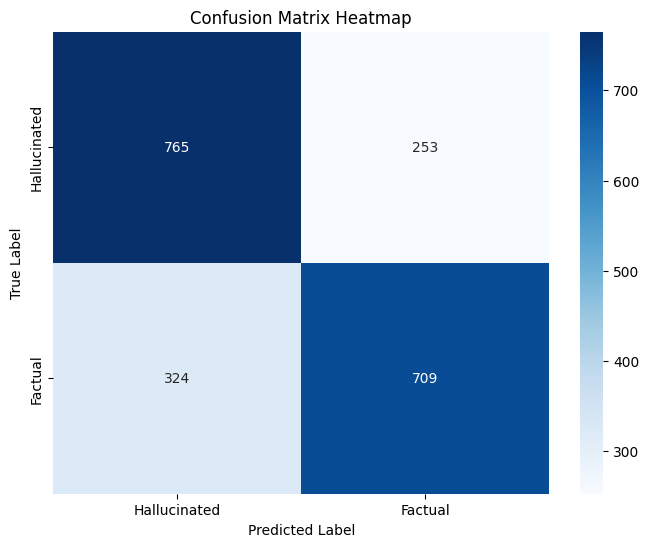

<ipython-input-34-d06f8812bfab>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_names, y=metrics, palette='viridis')


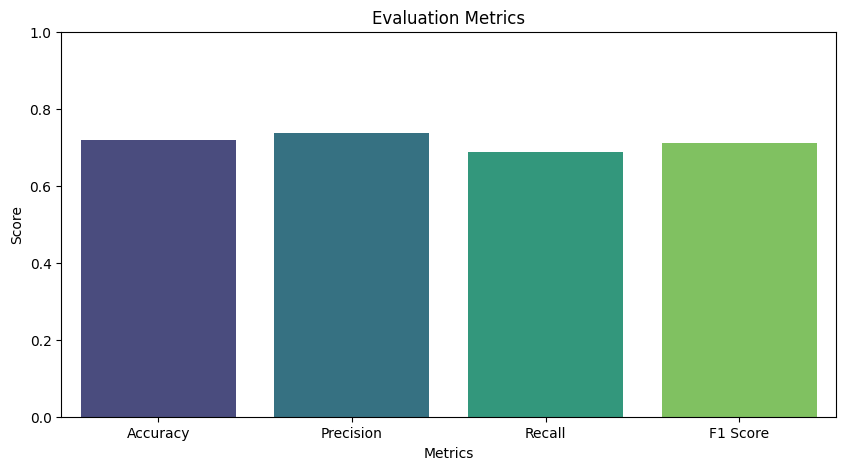

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Model Evaluation
y_pred = log_reg.predict(X_test_bow)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Hallucinated', 'Factual'], yticklabels=['Hallucinated', 'Factual'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotting evaluation metrics
metrics = [accuracy, precision, recall, f1]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(10, 5))
sns.barplot(x=metrics_names, y=metrics, palette='viridis')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.show()

In [36]:
def display_predictions(X_test, y_test, y_pred, num_predictions=5):
    # Sample a few indices for display
    sample_indices = np.random.choice(len(X_test), num_predictions, replace=False)

    print(f"{'Summary':<80} {'Actual':<10} {'Predicted':<10}")
    print("=" * 100)

    for index in sample_indices:
        summary = X_test[index]
        actual = 'Factual' if y_test[index] == 1 else 'Hallucinated'
        predicted = 'Factual' if y_pred[index] == 1 else 'Hallucinated'

        print(f"{summary:<80} {actual:<10} {predicted:<10}")

# Call the function to display predictions
display_predictions(X_test, y_test, y_pred, num_predictions=5)

Summary                                                                          Actual     Predicted 
ampere roman silver coin believed to equal i of britain's most famous roman coins has been discovered in norfolk. Factual    Factual   
a powerful earthquake has struck italy's southern central italy, killing at least two people, officials say. Hallucinated Hallucinated
a murder investigation has been launched after a man died following a lancinate assail on a house in south yorkshire. Factual    Hallucinated
Manchester united manager sir alex ferguson says He is not touch_on about his side's unbeaten start to the season as they attempt to win the premier league title Factual    Hallucinated
campaigners are calling for a vaccinating vaccination against cancer in wales.   Factual    Factual   


In [37]:
# Cross-Validation (k-fold)
def cross_validation(model, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracy_scores = []

    for train_index, val_index in kf.split(X):
        X_train_cv, X_val_cv = X[train_index], X[val_index]
        y_train_cv, y_val_cv = y[train_index], y[val_index]

        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_val_cv)
        accuracy_scores.append(accuracy_score(y_val_cv, y_pred_cv))

    return np.mean(accuracy_scores), np.std(accuracy_scores)

mean_accuracy, std_dev = cross_validation(log_reg, X_train_bow, y_train)
print(f"Cross-Validation Mean Accuracy: {mean_accuracy}")
print(f"Cross-Validation Standard Deviation: {std_dev}")

Cross-Validation Mean Accuracy: 0.7068998677189697
Cross-Validation Standard Deviation: 0.008645662628946105


In [38]:
# Error Analysis: Find misclassified examples
misclassified = X_test[np.where(y_test != y_pred)]
print("Misclassified Examples:")
for example in misclassified[:5]:
    print(example)

Misclassified Examples:
the jihadist group islamic state ( is ) is preparing to return home to syria, after being shot dead by islamic state militants.
plans to build a power plant in the centre of hinkley point have been suspended by the government, the government has said.
Italian prime minister matteo renzi has won the a_la_mode degree in a vote in italy's parliament.
testimonial have been paid to renowned renowned music music_director Saint_Christopher lee, who has died at the age of 86.
barrow came from behind to beat taunton atomic_number_49 the start round of the fa cup at the expense of league two.


# Error Analysis



1.   Many summaries contain ambiguous phrases or complex sentence structures that can be interpreted differently, making it challenging for the model to discern factual from hallucinated content.
2.   Summaries that use similar words but convey different meanings could be misclassified, as the model may not capture the nuances effectively.
3. Limited training data may also cause the model to misclassify few of the statements.
4. Texts with spelling mistakes or typographical errors can disrupt the tokenization process and affect the model’s ability to learn from the data.
5. The presence of uncommon or domain-specific terminology may not be well-represented in the training data, leading the model to misclassify them.

# Improvements

1. Explore word embeddings to capture semantic relationships between words.
2. Optimizing hyperparameters may improve the training process.
3. Experimenting with a more complex model may improve the results.




